In [1]:
# %pip install tensorflow==2.4.1
# %pip install transformers
# %pip install pyarrow
# %pip install tensorflow-addons

In [1]:
import tensorflow as tf
import pandas as pd
import pickle
import os
import tensorflow_addons as tfa
from math import ceil
from tensorflow.keras.utils import plot_model
from transformers import RobertaTokenizer, RobertaTokenizerFast, TFRobertaModel, TFAlbertModel

AUTO = tf.data.experimental.AUTOTUNE

In [2]:
model_iteration = 'iteration_final/basic_word_tokenized_500_test'

In [3]:
with open(f"./{model_iteration}/vocab/topics_vocab.pkl", "rb") as f:
    target_vocab = pickle.load(f)
    
target_vocab_inv = {j:i for i,j in target_vocab.items()}

with open(f"./{model_iteration}/vocab/doc_type_vocab.pkl", "rb") as f:
    doc_vocab = pickle.load(f)
    
doc_vocab_inv = {j:i for i,j in doc_vocab.items()}

with open(f"./{model_iteration}/vocab/journal_name_vocab.pkl", "rb") as f:
    journal_vocab = pickle.load(f)
    
journal_vocab_inv = {j:i for i,j in journal_vocab.items()}

with open(f"./{model_iteration}/vocab/paper_title_vocab.pkl", "rb") as f:
    title_vocab = pickle.load(f)
    
title_vocab_inv = {j:i for i,j in title_vocab.items()}

In [4]:
encoding_layer = tf.keras.layers.experimental.preprocessing.CategoryEncoding(
    max_tokens=len(target_vocab)+1, output_mode="binary", sparse=False)


In [5]:
len(title_vocab)

177567

In [6]:
len(target_vocab)

82178

In [8]:
mag_model = tf.keras.models.load_model(f'./{model_iteration}/models/gamma_28_nH8_nL6_epoch25/')

2021-11-25 23:06:01.068679: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-25 23:06:01.077543: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
mag_model.inputs

[<KerasTensor: shape=(None, 64) dtype=int64 (created by layer 'paper_title_ids')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'doc_type_id')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'journal_id')>]

In [10]:
final_model = tf.keras.Model(inputs=mag_model.inputs, 
                             outputs=tf.math.top_k(mag_model.outputs, k=30))

In [11]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
paper_title_ids (InputLayer)    [(None, 64)]         0                                            
__________________________________________________________________________________________________
title_embedding (Embedding)     (None, 64, 512)      90914816    paper_title_ids[0][0]            
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 64, 512)      0           title_embedding[0][0]            
__________________________________________________________________________________________________
encoder_0/multiheadattention (M (None, 64, 512)      1050624     tf.__operators__.add[0][0]       
                                                                 tf.__operators__.add[0][0]   

In [12]:
def get_all_model_predictions(data_path):
    # Get all of the files, load into single pandas dataframe
    # split up into blocks of 3000 and get model output
    file_names = [x for x in os.listdir(f"./{model_iteration}/tokenized_data/test/") if x.startswith('part')]
    file_names.sort()
    
    full_df = pd.DataFrame()
    
    for file_name in file_names:
        temp_df = pd.read_parquet(f"./{model_iteration}/tokenized_data/test/{file_name}")
        full_df = pd.concat([full_df, temp_df], axis=0)
    
    num_samples = 1000
    preds_final = []
    scores_final = []
    for i in range(ceil(full_df.shape[0]/num_samples)):
        print(i)
        small_df = full_df.iloc[i*num_samples:(i+1)*num_samples, :].copy()
        preds, scores = get_model_predictions(small_df)
        preds_final += preds
        scores_final += scores
    
    full_df['predictions'] = preds_final
    full_df['scores'] = scores_final
    
    return full_df


In [13]:
def get_model_predictions(input_data):
    
    paper_titles = tf.keras.preprocessing.sequence.pad_sequences(input_data['paper_title_tok'].to_list(), maxlen=64, 
                                                             dtype='int64', padding='post', 
                                                             truncating='post', value=0)
    
    doc_types = tf.convert_to_tensor(input_data['doc_type_tok'].to_list())
    journal = tf.convert_to_tensor(input_data['journal_tok'].to_list())
    
    model_output = final_model([paper_titles, doc_types, journal])
    
    scores = model_output.values.numpy()[0][:,:20].tolist()
    preds = model_output.indices.numpy()[0][:,:20].tolist()1`
    
    return preds, scores

In [14]:
test_data = get_all_model_predictions(f"./{model_iteration}/tokenized_data/test/")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97


In [16]:
test_data.to_parquet(f"./{model_iteration}/test_data/data_with_predictions_500_gamma28_nH8_nL6_epoch25.parquet")

In [15]:
# test_data = pd.read_parquet(f"./{model_iteration}/test_data/data_with_predictions_500.parquet")
test_data['target_test'] = test_data['target_tok'].apply(lambda x: [i for i in x if i!=-1])
test_data['target_test'] = test_data['target_test'].apply(len)
test_data = test_data[test_data['target_test'] > 0].copy()

In [16]:
test_data.shape

(97233, 9)

In [17]:
test_data.sample(5)

,paper_id,publication_date,doc_type_tok,journal_tok,target_tok,paper_title_tok,predictions,scores,target_test
23907,3131361924,2021-07-01,[3],[294],"[1715, 101, 2, 1381]","[168800, 166817, 107386, 126558, 151334, 17634...","[2, 1381, 42, 171, 37, 306, 156, 11791, 543, 1...","[0.641745388507843, 0.4675076901912689, 0.4003...",4
1629,2173313759,1971-12-01,[3],[2775],"[2076, 8, 2685, 49, 3770, 388, 239, 2736, 1524...","[161506, 64102, 37508, 126553, 97706, 151326, ...","[8, 49, 239, 95, 696, 2736, 2685, 685, 5727, 3...","[0.7249653339385986, 0.4582909345626831, 0.438...",10
4440,2357299977,2013-03-01,[3],[1039],"[1425, 5, 328, 81, 691, 1835, 478, 586, 251, 8...","[35688, 633, 117665, 162290, 14251, 126553, 13...","[5, 8493, 586, 691, 328, 251, 623, 42, 397, 47...","[0.6601946353912354, 0.6510505080223083, 0.572...",11
8505,2747201174,2017-09-29,[3],[5623],"[61, 1, 38146, 443]","[103617, 14805, 112377, 131258, 152551, 150768...","[1, 6, 31, 2024, 38146, 2181, 61, 76, 85, 1967...","[0.9602290391921997, 0.5080435276031494, 0.466...",4
18728,3134951874,2021-06-01,[3],[2384],"[774, 2, 37, 16104, 14212, 3972, 215, 4050, 79...","[100107, 17828, 126553, 53496, 133601, 166817,...","[79, 1708, 2, 774, 1139, 215, 14212, 44, 29434...","[0.8013430237770081, 0.688534677028656, 0.6055...",10


In [6]:
import os
import pandas as pd

In [9]:
test_data_raw = pd.DataFrame()
for i in os.listdir("./iteration_final/test_data_raw/"):
    if i.startswith('part'):
        temp_df = pd.read_parquet(f"./iteration_final/test_data_raw/{i}")
        test_data_raw = pd.concat([test_data_raw, temp_df])

In [11]:
test_data_raw.head()

,paper_id,doc_type,paper_title,journal_name,publication_date,topics
0,11688300,None,solving the traveling salesman problem in micr...,None,2010-01-01,"[microsoft excel, computer science, travelling..."
1,13187899,Conference,expression recognition in videos using a weigh...,None,2011-05-01,"[component, computer vision, computer science,..."
2,21335690,None,anisotropy of defect production in electron ir...,None,1968-10-31,"[crystallography, electron, silicon, materials..."
3,30574182,Patent,sprinkler trim ring,None,2000-02-03,"[engineering, structural engineering, trim, ri..."
4,47556196,Conference,the use of formal and informal models in objec...,None,2001-01-01,"[requirement, non functional requirement, soft..."


In [12]:
test_data_raw.to_parquet("test_raw.parquet")

### Putting Everything Together

In [19]:
def get_metrics(data, target_col, predict_col):
    targets = tf.keras.preprocessing.sequence.pad_sequences(data[target_col].to_list(), maxlen=20, 
                                                            dtype='int64', padding='post', 
                                                            truncating='post', value=0)
    targets = tf.RaggedTensor.from_tensor(targets, padding=0)
    targets = encoding_layer(targets)
    
    predictions = tf.keras.preprocessing.sequence.pad_sequences(data[predict_col].to_list(), maxlen=30, 
                                                                dtype='int64', padding='post', 
                                                                truncating='post', value=0)
    predictions = tf.RaggedTensor.from_tensor(predictions, padding=0)
    predictions = encoding_layer(predictions)
    
    recall_score = tf.keras.metrics.Recall()
    precision_score = tf.keras.metrics.Precision()
    
    recall_score.update_state(targets,predictions)
    precision_score.update_state(targets,predictions)
    
    print(f"Recall: {round(recall_score.result().numpy()*100, 1)}%")
    print(f"Precision: {round(precision_score.result().numpy()*100, 1)}%")

In [ ]:
get_metrics(test_data, 'target_tok', 'predictions')

### Quick Sample of Targets vs Predictions

In [ ]:
sample_data = test_data.sample(10)
for i,j in zip(sample_data['target_tok'].to_list(),sample_data['predictions'].to_list()):
    print("Targets:")
    print([target_vocab_inv.get(x) for x in i])
    print("\n")
    print("Predictions:")
    print([target_vocab_inv.get(x) for x in j])
    print("-----------------------------------------------------------------------------")
    print("\n")

In [ ]:
for i,j in target_vocab_inv.items():
    if i < 50:
        print(f"{i}: {j}")

In [ ]:
level_ones = [2,3,4,5,6,7,11,12,13,14,16,18,19,21,24,29,32]

### Get metrics for different levels

In [ ]:
# need to get df that contains the tag and the appropriate level (get only tags that show up in vocab)
# also need to match up the tag with the tag_id from the vocab

In [ ]:
levels_df = pd.read_parquet("./test_data_files/tag_levels.parquet").fillna(6)
levels_df['level'] = levels_df['level'].astype('int')
# levels_df = pd.DataFrame(zip(level_ones, [1]*len(level_ones)), columns=['tag','level'])

In [ ]:
levels_df['level'].value_counts()

In [ ]:
def get_df_for_specific_level(old_df, levels, level_to_get=1):
    df = old_df.copy()
    tags_list = levels[levels['level']==level_to_get]['topic_name'].to_list()
    tags_id_list = [target_vocab.get(x) for x in tags_list]
    print(f"Number of Level {level_to_get} Tags: {len(tags_list)}")
    
    df[f'tags_level_{level_to_get}'] = df['target_tok'].apply(lambda x: [i for i in x if i in tags_id_list])
    df[f'preds_level_{level_to_get}'] = df['predictions'].apply(lambda x: [i for i in x if i in tags_id_list])
    
    df[f'tag_level_{level_to_get}_len'] = df[f'tags_level_{level_to_get}'].apply(len)
    df[f'pred_level_{level_to_get}_len'] = df[f'preds_level_{level_to_get}'].apply(len)
    
    papers_with_tag = (df[df[f'tag_level_{level_to_get}_len'] > 0].shape[0])/df.shape[0]
    papers_with_pred = (df[df[f'pred_level_{level_to_get}_len'] > 0].shape[0])/df.shape[0]
    
    print(f"Percentage of papers with Level {level_to_get} Tags: {round(papers_with_tag*100, 1)}")
    print(f"Percentage of papers with Level {level_to_get} Preds: {round(papers_with_pred*100, 1)}")
    
    return df

In [ ]:
level_to_check = 0
df = get_df_for_specific_level(test_data, levels_df, level_to_check)
get_metrics(df, f"tags_level_{level_to_check}", f"preds_level_{level_to_check}")

In [ ]:
level_to_check = 1
df = get_df_for_specific_level(test_data, levels_df, level_to_check)
get_metrics(df, f"tags_level_{level_to_check}", f"preds_level_{level_to_check}")

In [ ]:
level_to_check = 2
df = get_df_for_specific_level(test_data, levels_df, level_to_check)
get_metrics(df, f"tags_level_{level_to_check}", f"preds_level_{level_to_check}")

In [ ]:
level_to_check = 3
df = get_df_for_specific_level(test_data, levels_df, level_to_check)
get_metrics(df, f"tags_level_{level_to_check}", f"preds_level_{level_to_check}")

In [ ]:
level_to_check = 4
df = get_df_for_specific_level(test_data, levels_df, level_to_check)
get_metrics(df, f"tags_level_{level_to_check}", f"preds_level_{level_to_check}")

In [ ]:
level_to_check = 5
df = get_df_for_specific_level(test_data, levels_df, level_to_check)
get_metrics(df, f"tags_level_{level_to_check}", f"preds_level_{level_to_check}")

In [ ]:
level_to_check = 6
df = get_df_for_specific_level(test_data, levels_df, level_to_check)
get_metrics(df, f"tags_level_{level_to_check}", f"preds_level_{level_to_check}")

### Looking into Data Available vs Not Available

In [42]:
test_data['journal'] = test_data['journal_tok'].apply(lambda x: [journal_vocab_inv.get(i) for i in x][0])
test_data['doc_type'] = test_data['doc_type_tok'].apply(lambda x: [doc_vocab_inv.get(i) for i in x][0])

In [49]:
test_data.head(1)

,paper_id,publication_date,doc_type_tok,journal_tok,target_tok,paper_title_tok,paper_title_mask,predictions,scores,journal,doc_type,paper_title_tok_len
16657,2604922879,2001-11-28,[4],[2],[2],"[2, 2494, 5036, 43, 2373, 2110, 203, 14923, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[4, 2, 157, 87, 78, 10, 28, 286, 167, 339, 48,...","[0.6048187017440796, 0.3559792637825012, 0.291...",[NONE],Patent,47


In [47]:
test_data['doc_type'].value_counts().index

Index(['Journal', 'Patent', '[NONE]', 'Conference', 'Repository', 'Thesis',
       'Book', 'BookChapter'],
      dtype='object')

##### Different Doc Types

In [52]:
for doc_type in test_data['doc_type'].value_counts().index:
    print(doc_type)
    get_metrics(test_data[test_data['doc_type']==doc_type], "target_tok", "predictions")
    print("-----------------------------------------------------------------------")
    print("\n")

Journal
Recall: 49.2%
Precision: 27.9%
-----------------------------------------------------------------------


Patent
Recall: 48.3%
Precision: 24.3%
-----------------------------------------------------------------------


[NONE]
Recall: 51.5%
Precision: 21.0%
-----------------------------------------------------------------------


Conference
Recall: 45.7%
Precision: 28.6%
-----------------------------------------------------------------------


Repository
Recall: 45.7%
Precision: 25.8%
-----------------------------------------------------------------------


Thesis
Recall: 52.6%
Precision: 24.1%
-----------------------------------------------------------------------


Book
Recall: 57.6%
Precision: 20.7%
-----------------------------------------------------------------------


BookChapter
Recall: 68.4%
Precision: 17.3%
-----------------------------------------------------------------------




##### Journal vs No Journal

### Looking into Journal Title Length

In [48]:
test_data['paper_title_tok_len'] = test_data['paper_title_tok'].apply(len)

<AxesSubplot:ylabel='Frequency'>

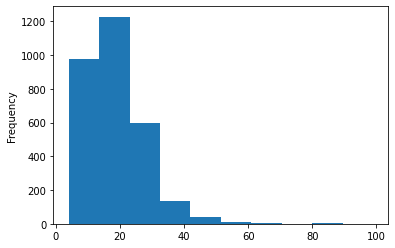

In [50]:
test_data['paper_title_tok_len'].plot.hist()

In [ ]:
# 0 - 20, 20 - 40, 40+